In [22]:
import tensorflow as tf

from tensorflow import keras
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Activation
from keras.layers.experimental.preprocessing import Resizing
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

In [24]:
X, y = pd.read_pickle("/content/drive/MyDrive/train.pkl")

In [25]:
num_classes = len(np.unique(y))
num_classes

36

### Resizing

In [42]:
def plot_resize(idx, X):

  preprocessing = Resizing(28, 28)
  X_train = X.reshape(-1, 56, 56, 1)
  X_processed = preprocessing(X_train)

  fig, axes = plt.subplots(1, 2)
  fig.suptitle(f'Original vs resized 28x28')

  axes[0].imshow(X_train[idx].reshape(56,56))
  axes[1].imshow(X_processed[idx].numpy().reshape(28,28))  
  fig.savefig(f'{idx}_resized.png')

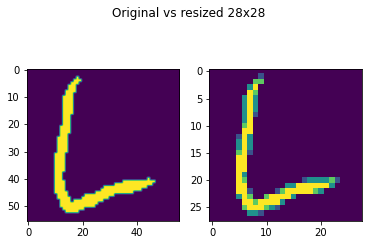

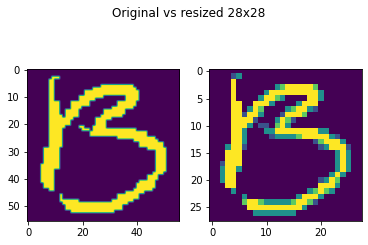

In [43]:
plot_resize(10, X)
plot_resize(222, X)

Note: Resizing to 28X28 does not change the interpretability of the image and still allows to reduce the size of the image 4 times. 

## Model selection

Because of high GPU/TPU usage, cross validation will not be used in experiments. However, the sample from class 30 will be manually added to training set.

In [29]:
def check_and_swap_for_single_example(X_train, X_test, y_train, y_test, verbose=False):
    single_label = 30
    if np.any(y_train == single_label):
        if verbose:
            print("No need for swap")
        pass
    else:
        if verbose:
            print("Swapping needed")
        idx = np.where(y_test == single_label)[0]
        row_to_append = X_test[idx]
        label_to_append = y_test[idx]
        X_train = np.vstack([X_train, row_to_append])
        y_train = np.vstack([y_train, label_to_append])
        X_test = np.delete(X_test, idx, axis=0)
        y_test = np.delete(y_test, idx, axis=0)
        
    return X_train, X_test, y_train, y_test

In [30]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = check_and_swap_for_single_example(X_train, X_test, y_train, y_test, verbose=True)

No need for swap


In [31]:
X_train = X_train.reshape(-1, 56, 56, 1)
X_test = X_test.reshape(-1, 56, 56, 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Model architecture
In order to find the optimal CNN architecture, following questions need to be answered:
1. How deep should the model be?
2. How many filter maps should the Conv2D layers have?
3. What is the best size of dense layer?
4. Which regularization technique works the best and/or which percentage of Dropout gives the best results?
5. Is the training dataset enough or is there a need for data augumentation?





In [8]:
epochs = 20
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [12]:
class MetricsCallback(keras.callbacks.Callback):

    def __init__(self, train_images, train_labels, val_images, val_labels):
        super(MetricsCallback, self).__init__()
        self.train_images = train_images
        self.train_labels = train_labels
        self.val_images = val_images
        self.val_labels = val_labels

    def on_train_begin(self, logs={}):
        self.train_f_scores_macro = []
        self.train_f_scores_micro = []
        self.val_f_scores_macro = []
        self.val_f_scores_micro = []
        self.train_accuracy = []
        self.val_accuracy = []

    def on_epoch_end(self, epoch, logs={}):
        indexes = tf.argmax(self.model.predict(self.train_images),axis=1)
        indexes = tf.expand_dims(indexes, axis=1)

        train_f_score_macro = f1_score(self.train_labels, indexes, average='macro')
        train_f_score_micro = f1_score(self.train_labels, indexes, average='micro')
        train_accuracy = accuracy_score(self.train_labels, indexes)

        self.train_f_scores_macro.append(train_f_score_macro)
        self.train_f_scores_micro.append(train_f_score_micro)
        self.train_accuracy.append(train_accuracy)

        val_indexes = tf.argmax(self.model.predict(self.val_images), axis=1)
        val_indexes = tf.expand_dims(val_indexes, axis=1)

        val_f_score_macro = f1_score(self.val_labels, val_indexes, average='macro')
        val_f_score_micro = f1_score(self.val_labels, val_indexes, average='micro')
        val_accuracy = accuracy_score(self.val_labels, val_indexes)

        self.val_f_scores_macro.append(val_f_score_macro)
        self.val_f_scores_micro.append(val_f_score_micro)
        self.val_accuracy.append(val_accuracy)

        return

In [45]:
def plot_metrics_for_experiment(nets_history, net_f1scores, experiment_name, names, truncate=False, truncation=0.85):

  styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16,16), constrained_layout=True)
  fig.suptitle(f'Metrics for experiment {experiment_name}')

  for i in range(len(nets_history)):
    if '+DA' in names[i]:
      ax1.plot(net_f1scores[i]['val_accuracy'], linestyle=styles[i])
    else:
      ax1.plot(nets_history[i].history['val_accuracy'], linestyle=styles[i])
  for i in range(len(nets_history)):
    ax2.plot(net_f1scores[i]['val_f1_macro'], linestyle=styles[i])
  for i in range(len(nets_history)):
    ax3.plot(net_f1scores[i]['val_f1_micro'], linestyle=styles[i])
  for i in range(len(nets_history)):
    ax4.plot(nets_history[i].history['val_loss'],linestyle=styles[i])

  ax1.title.set_text('Accuracy on validation set')
  ax1.set_ylim([None,1])
  ax1.set_xlabel('epoch', fontsize=10)
  ax1.set_ylabel('accuracy', fontsize='medium') 

  ax2.title.set_text('F1 macro on validation set')
  ax2.set_ylim([None,1])
  ax2.set_xlabel('epoch', fontsize=10)
  ax2.set_ylabel('f1 macro', fontsize='medium') 

  ax3.title.set_text('F1 micro on validation set')
  ax3.set_ylim([None,1])
  ax3.set_xlabel('epoch', fontsize=10)
  ax3.set_ylabel('f1 micro', fontsize='medium') 

  ax4.title.set_text('Loss on validation set')
  ax4.set_xlabel('epoch', fontsize=10)
  ax4.set_ylabel('loss', fontsize='medium') 
  if truncate:
    ax1.set_ylim([truncation,1])
    ax2.set_ylim([truncation,1])
    ax3.set_ylim([truncation,1])

  ax1.legend(names)
  ax2.legend(names)
  ax3.legend(names)
  ax4.legend(names)

  fig.savefig(f'{experiment_name}_results.png')


## Experiment 1
This experiment will show how many convolution - subsampling pairs should the model have. The combinations of layers follow:


*   Input -   
Conv2D(filters=24, kernel_size=5) - MaxPool2D -  
 Dense(256) - Dense(10)
*   Input -  
 Conv2D(filters=24, kernel_size=5) - MaxPool2D -  
 Conv2D(filters=48, kernel_size=5) - MaxPool2D -  
 Dense(256) - Dense(10)
*   Input -   
Conv2D(filters=24, kernel_size=5) - MaxPool2D -  
Conv2D(filters=48, kernel_size=5) - MaxPool2D -  
Conv2D(filters=64, kernel_size=5) - MaxPool2D -  
Dense(256) - Dense(10)

After third MaxPool2d layer the image will be reduced to 4x4 (with padding same). So it makes no sense to add fourth pair.

In [14]:
experiment_nets = 3
model = [0]*experiment_nets 

for m in range(experiment_nets):
  model[m] = Sequential()
  model[m].add(Resizing(28, 28))
  model[m].add(Conv2D(filters=24, kernel_size=5, padding='same', activation='relu', input_shape=(28,28,1)))
  model[m].add(MaxPool2D())
  if m > 0:
    model[m].add(Conv2D(filters=48, kernel_size=5, padding='same', activation='relu'))
    model[m].add(MaxPool2D())
  if m > 1:
    model[m].add(Conv2D(filters=64, kernel_size=5, padding='same', activation='relu'))
    model[m].add(MaxPool2D())
  model[m].add(Flatten())
  model[m].add(Dense(256, activation='relu'))
  model[m].add(Dense(num_classes, activation='softmax'))
  model[m].compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics='accuracy')

In [15]:
history_1 = [0]*experiment_nets
f1_metrics_1 = [0]*experiment_nets


for m in range(experiment_nets):
  fscore_metrics = MetricsCallback(X_train, y_train, X_test, y_test)
  history_1[m] = model[m].fit(X_train, y_train, batch_size=80, epochs = epochs, 
        validation_data = (X_test, y_test), callbacks=[annealer, fscore_metrics],
        verbose=False)
  f1_metrics_1[m] = {"train_f1_macro": fscore_metrics.train_f_scores_macro,
                   "train_f1_micro": fscore_metrics.train_f_scores_micro,
                   "val_f1_macro": fscore_metrics.val_f_scores_macro,
                   "val_f1_micro": fscore_metrics.val_f_scores_micro
                  }
  print(f"Model {m}: Epochs={epochs} Train acc:{ max(history_1[m].history['accuracy'])} Val acc:{ max(history_1[m].history['val_accuracy']) }  Train f1: { max(fscore_metrics.train_f_scores_macro) } Val f1:{ max(fscore_metrics.val_f_scores_macro) }")


Model 0: Epochs=20 Train acc:0.9930160045623779 Val acc:0.9314228296279907  Train f1: 0.9868012512507226 Val f1:0.8599499749792697
Model 1: Epochs=20 Train acc:0.9856357574462891 Val acc:0.941277027130127  Train f1: 0.9709082267748417 Val f1:0.8753325671011377
Model 2: Epochs=20 Train acc:0.983902096748352 Val acc:0.9427853226661682  Train f1: 0.9732982377357471 Val f1:0.8798101354378832


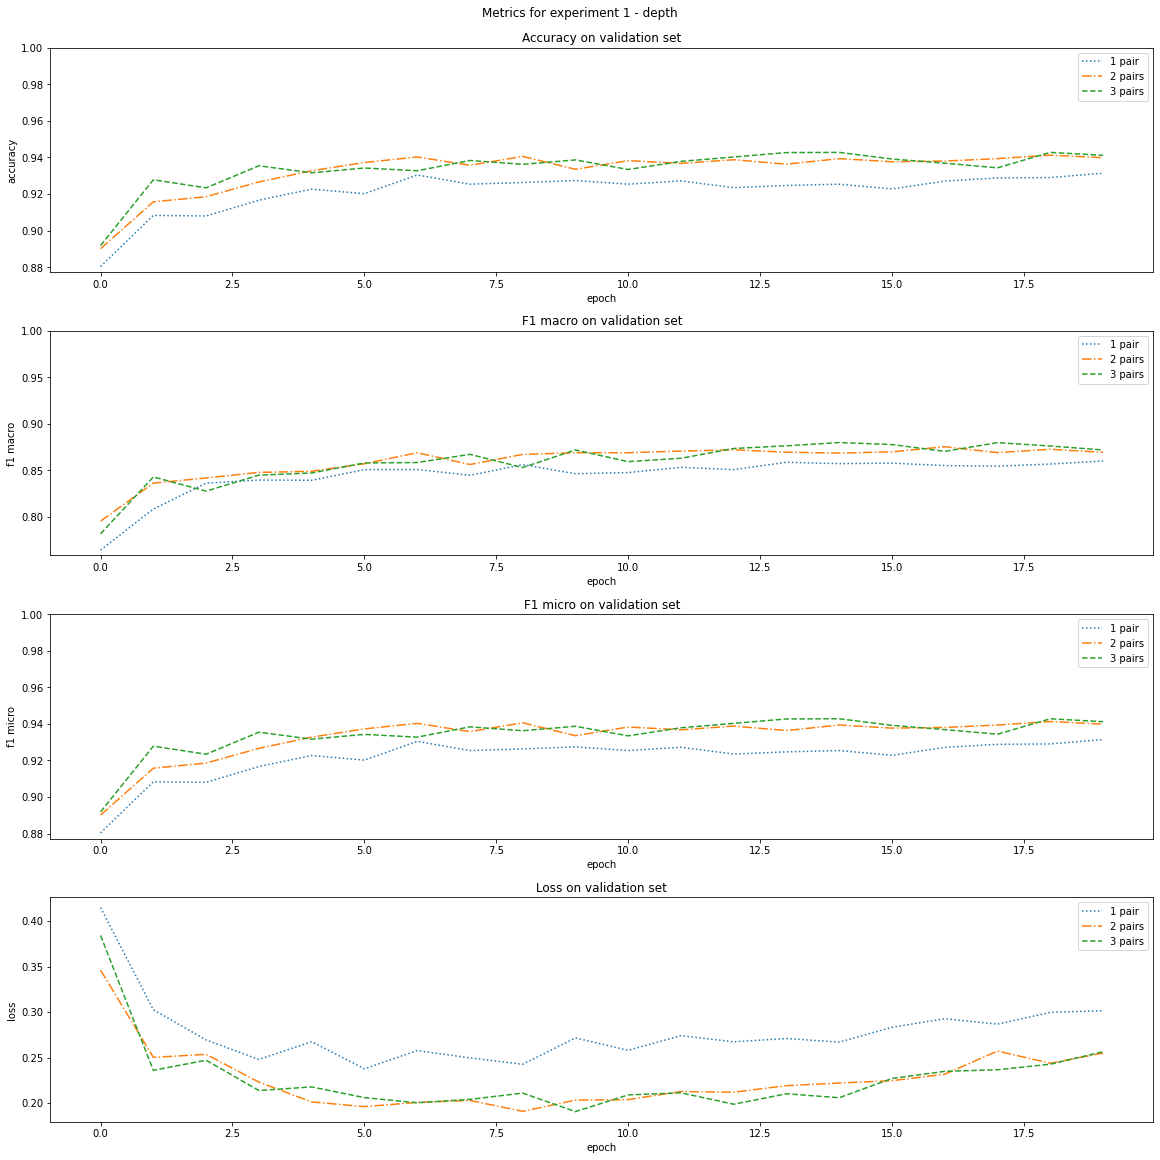

In [36]:
plot_metrics_for_experiment(history_1, 
                            f1_metrics_1, 
                            '1 - depth',
                            ['1 pair', '2 pairs', '3 pairs'])

### Summary
The worst results were achieved using only one pair [Conv2d, MaxPool2d]. The results of 2 and 3 pairs are very similar, but for efficiency the architecture with 2 pairs will be used.

## Experiment 2
This experiment is expected to decide, which combination of feature map numbers will be used. The tested combinations follow (for clarity, Input and Dense layers will be omitted):


*   Conv2D(f=8, k_s=5) - MP2D - Conv2D(f=16, k_s=5) - MP2D
*   Conv2D(f=16, k_s=5) - MP2D - Conv2D(f=32, k_s=5) - MP2D
*   Conv2D(f=24, k_s=5) - MP2D - Conv2D(f=48, k_s=5) - MP2D
*   Conv2D(f=32, k_s=5) - MP2D - Conv2D(f=64, k_s=5) - MP2D
*   Conv2D(f=48, k_s=5) - MP2D - Conv2D(f=96, k_s=5) - MP2D



In [21]:
experiment_nets = 5
model = [0]*experiment_nets 

for m in range(experiment_nets):
  model[m] = Sequential()
  model[m].add(Resizing(28, 28))
  model[m].add(Conv2D(filters=m*8+8, kernel_size=5, strides=(1,1),  activation='relu', input_shape=(28,28,1)))
  model[m].add(MaxPool2D(strides=(2,2)))
  model[m].add(Conv2D(filters=m*16+16, kernel_size=5, strides=(1,1), activation='relu'))
  model[m].add(MaxPool2D(strides=(2,2)))
  model[m].add(Flatten())
  model[m].add(Dense(256, activation='relu'))
  model[m].add(Dense(num_classes, activation='softmax'))
  model[m].compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics='accuracy')

In [22]:
history_2 = [0]*experiment_nets
f1_metrics_2 = [0]*experiment_nets

for m in range(experiment_nets):
  f1_metrics = MetricsCallback(X_train, y_train, X_test, y_test)
  history_2[m] = model[m].fit(X_train, y_train, batch_size=80, epochs = epochs, 
        validation_data = (X_test, y_test), callbacks=[annealer, fscore_metrics],
        verbose=False)
  f1_metrics_2[m] = {"train_f1_macro": fscore_metrics.train_f_scores_macro,
                   "train_f1_micro": fscore_metrics.train_f_scores_micro,
                   "val_f1_macro": fscore_metrics.val_f_scores_macro,
                   "val_f1_micro": fscore_metrics.val_f_scores_micro
                  }
  print(f"Model {m}: Epochs={epochs} Train acc:{ max(history_2[m].history['accuracy'])} Val acc:{ max(history_2[m].history['val_accuracy']) }  Train f1: { max(fscore_metrics.train_f_scores_macro) } Test f1:{ max(fscore_metrics.val_f_scores_macro) }")


Model 0: Epochs=20 Train acc:0.970082700252533 Val acc:0.9345399737358093  Train f1: 0.9433855545129995 Test f1:0.8585141451632612
Model 1: Epochs=20 Train acc:0.9767199754714966 Val acc:0.9349421858787537  Train f1: 0.9601181508968383 Test f1:0.8653745526925738
Model 2: Epochs=20 Train acc:0.9797414541244507 Val acc:0.9376571178436279  Train f1: 0.9657237368645275 Test f1:0.8652455380800006
Model 3: Epochs=20 Train acc:0.9820694327354431 Val acc:0.9394670724868774  Train f1: 0.9684928385220761 Test f1:0.8730742227708012
Model 4: Epochs=20 Train acc:0.983753502368927 Val acc:0.9381598830223083  Train f1: 0.9672914661132739 Test f1:0.8718928969624321


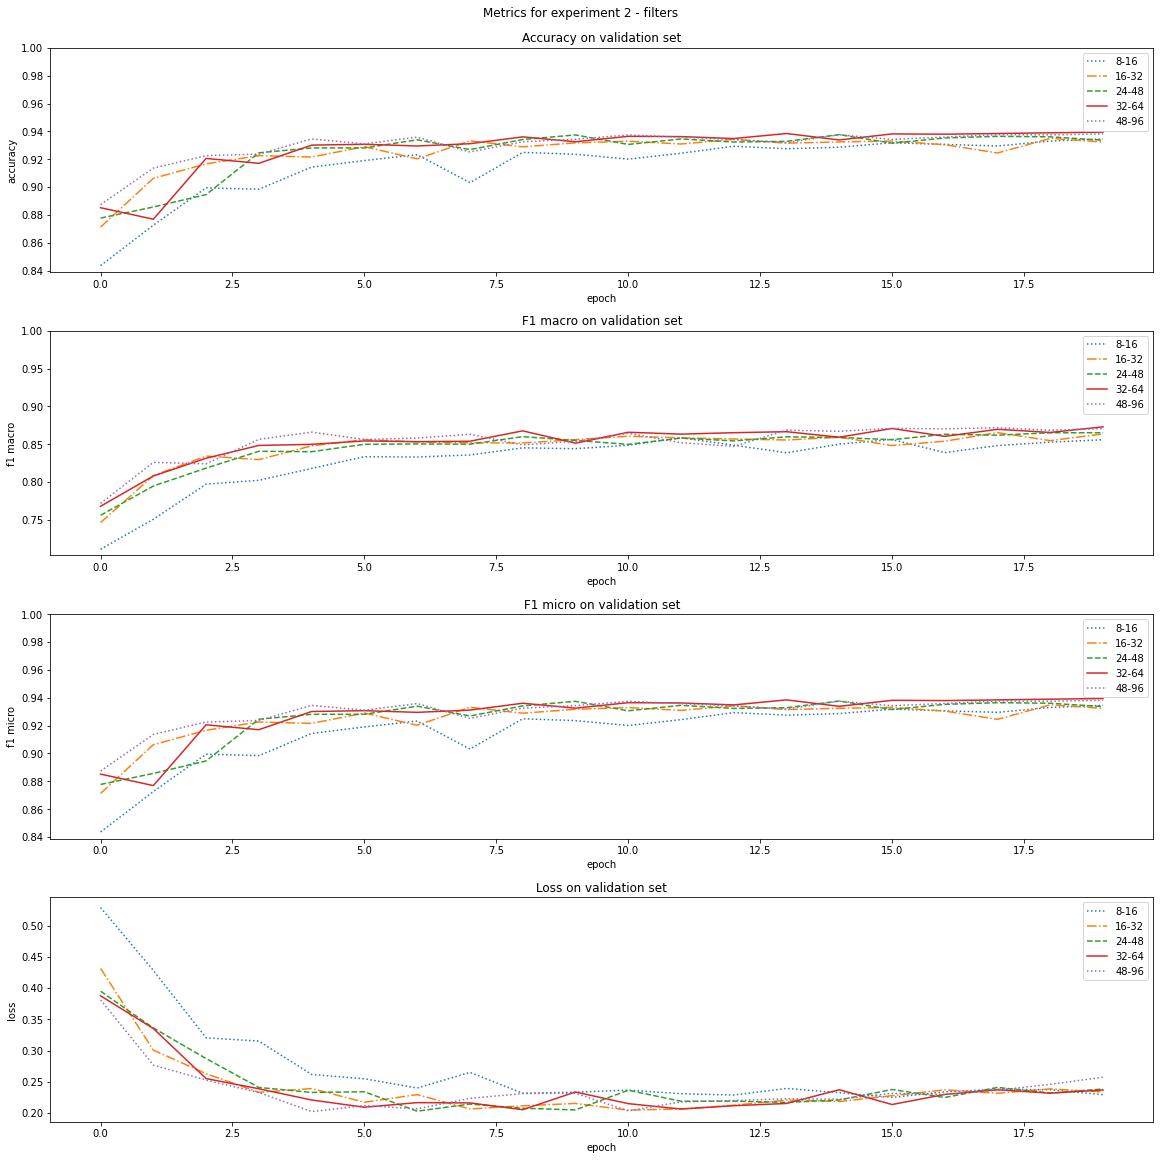

In [37]:
plot_metrics_for_experiment(history_2, 
                            f1_metrics_2, 
                            '2 - filters',
                            ['8-16', '16-32', '24-48', '32-64', '48-96'])

### Summary
The best filter sizes are 32-64 and 48-96, but the difference is very small and not worth the computational cost of achitecture with more feature maps.

## Experiment 3
This experiment will test several suggested dense layer sizes as follows:


*   0
*   32
*   64
*   128
*   256
*   512
*   1024



In [25]:
experiment_nets = 7
model = [0]*experiment_nets

for m in range(experiment_nets):
    model[m] = Sequential()
    model[m].add(Resizing(28, 28))
    model[m].add(Conv2D(filters=32, kernel_size=5, activation='relu', input_shape=(28,28,1)))
    model[m].add(MaxPool2D())
    model[m].add(Conv2D(filters=64, kernel_size=5, activation='relu'))
    model[m].add(MaxPool2D())
    model[m].add(Flatten())
    if m > 0:
      model[m].add(Dense(2**(m+4), activation='relu'))
    model[m].add(Dense(num_classes, activation='softmax'))
    model[m].compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics='accuracy')

In [38]:
history_3 = [0]*experiment_nets
f1_metrics_3 = [0]*experiment_nets

for m in range(experiment_nets):
  f1_metrics = MetricsCallback(X_train, y_train, X_test, y_test)
  history_3[m] = model[m].fit(X_train, y_train, batch_size=80, epochs = epochs, 
        validation_data = (X_test, y_test), callbacks=[annealer, fscore_metrics],
        verbose=False)
  f1_metrics_3[m] = {"train_f1_macro": fscore_metrics.train_f_scores_macro,
                   "train_f1_micro": fscore_metrics.train_f_scores_micro,
                   "val_f1_macro": fscore_metrics.val_f_scores_macro,
                   "val_f1_micro": fscore_metrics.val_f_scores_micro
                  }
  print(f"Model {m}: Epochs={epochs} Train acc:{ max(history_3[m].history['accuracy'])} Val acc:{ max(history_3[m].history['val_accuracy']) }  Train f1: { max(fscore_metrics.train_f_scores_macro) } Test f1:{ max(fscore_metrics.val_f_scores_macro) }")


Model 0: Epochs=20 Train acc:0.9947496056556702 Val acc:0.930618405342102  Train f1: 0.9921011537254366 Test f1:0.8646562700991833
Model 1: Epochs=20 Train acc:0.9841498136520386 Val acc:0.9326294660568237  Train f1: 0.9769144057875037 Test f1:0.8586061063706045
Model 2: Epochs=20 Train acc:0.989598274230957 Val acc:0.9364504814147949  Train f1: 0.9812828763724344 Test f1:0.8692305972498267
Model 3: Epochs=20 Train acc:0.9932141304016113 Val acc:0.9330316781997681  Train f1: 0.9891960285798294 Test f1:0.8666333416545425
Model 4: Epochs=20 Train acc:0.99415522813797 Val acc:0.9360482692718506  Train f1: 0.9914413972267483 Test f1:0.8791525755978149
Model 5: Epochs=20 Train acc:0.9922730326652527 Val acc:0.9404726028442383  Train f1: 0.986078393886727 Test f1:0.8767898602440999
Model 6: Epochs=20 Train acc:0.986626386642456 Val acc:0.9421820044517517  Train f1: 0.973875897588329 Test f1:0.8777126541934244


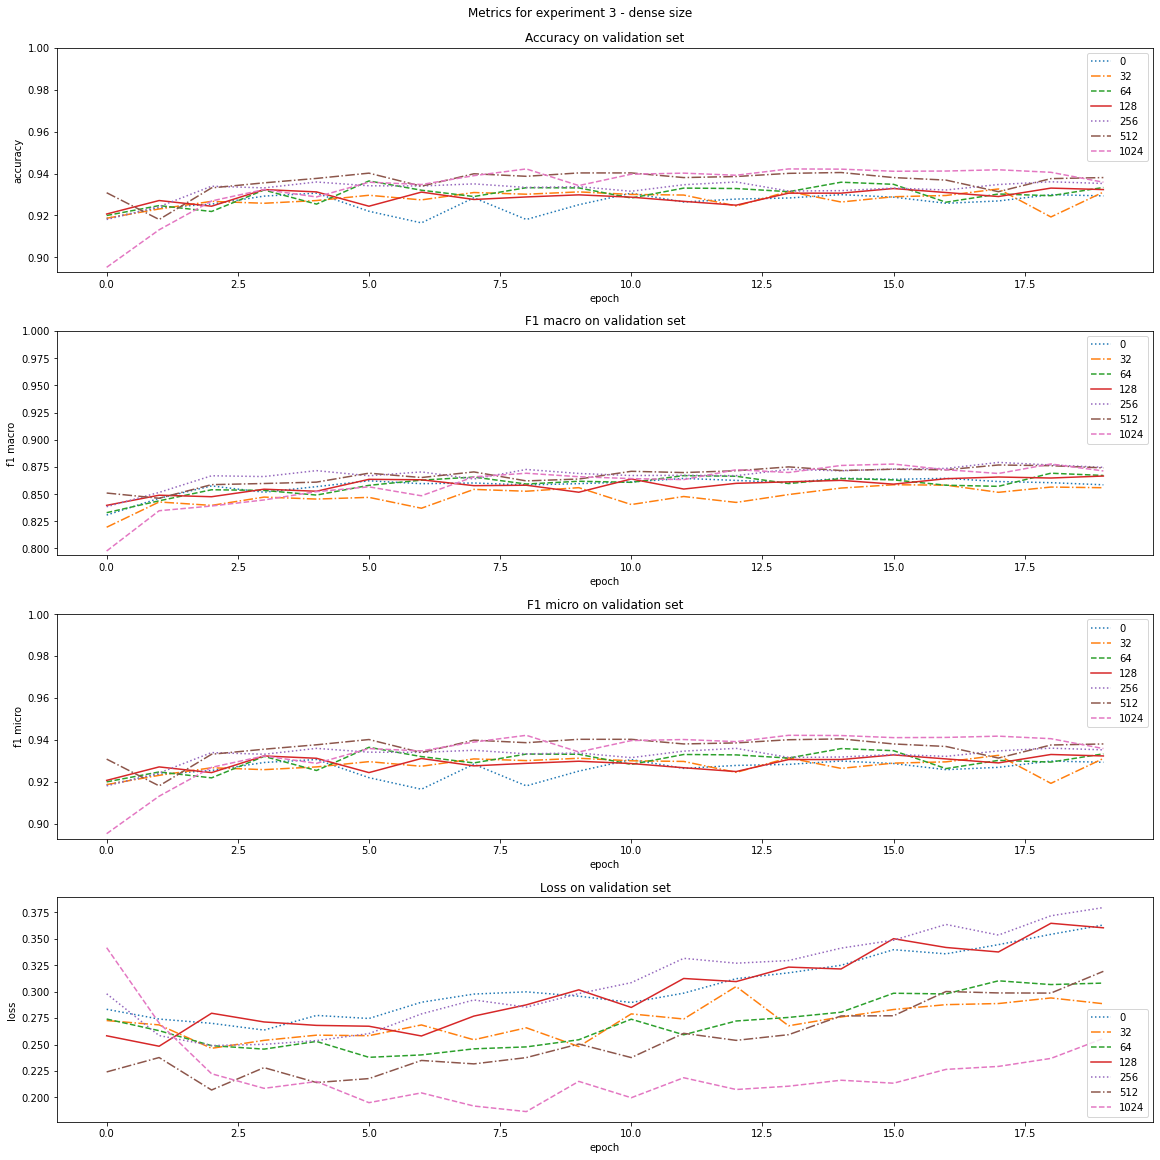

In [39]:
plot_metrics_for_experiment(history_3, 
                            f1_metrics_3, 
                            '3 - dense size',
                            ['0', '32', '64', '128', '256', '512', '1024'])

### Summary

Dense layers with more parameters perform slightly better. Again, taking into consideration the computational cost and memory usage, the best choice seems to be 256. This size will be used in further experiments.



## Experiment 4

One of regularization techniques is dropout - it prevents the network from overfitting by "turning off" random units. The amount of units dropped is specified by percentage. The tested values of dropout are [0%, 10%, 20%, 30%, 40%, 50%, 60%].



In [40]:
experiment_nets = 7
model = [0]*experiment_nets

for m in range(experiment_nets):
    model[m] = Sequential()
    model[m].add(Resizing(28, 28))
    model[m].add(Conv2D(filters=32, kernel_size=5, activation='relu', input_shape=(28,28,1)))
    model[m].add(MaxPool2D())
    model[m].add(Dropout(m*0.1))
    model[m].add(Conv2D(filters=64, kernel_size=5, activation='relu'))
    model[m].add(MaxPool2D())
    model[m].add(Dropout(m*0.1))
    model[m].add(Flatten())
    model[m].add(Dense(256, activation='relu'))
    model[m].add(Dropout(m*0.1))
    model[m].add(Dense(num_classes, activation='softmax'))
    model[m].compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics='accuracy')

In [41]:
history_4 = [0]*experiment_nets
f1_metrics_4 = [0]*experiment_nets

for m in range(experiment_nets):
  f1_metrics = MetricsCallback(X_train, y_train, X_test, y_test)
  history_4[m] = model[m].fit(X_train, y_train, batch_size=80, epochs = epochs, 
        validation_data = (X_test, y_test), callbacks=[annealer, fscore_metrics],
        verbose=False)
  f1_metrics_4[m] = {"train_f1_macro": fscore_metrics.train_f_scores_macro,
                   "train_f1_micro": fscore_metrics.train_f_scores_micro,
                   "val_f1_macro": fscore_metrics.val_f_scores_macro,
                   "val_f1_micro": fscore_metrics.val_f_scores_micro
                  }
  print(f"Model {m}: Epochs={epochs} Train acc:{ max(history_4[m].history['accuracy'])} Val acc:{ max(history_4[m].history['val_accuracy']) }  Train f1: { max(fscore_metrics.train_f_scores_macro) } Test f1:{ max(fscore_metrics.val_f_scores_macro) }")


Model 0: Epochs=20 Train acc:0.9827133417129517 Val acc:0.9392659664154053  Train f1: 0.9721136935064778 Test f1:0.8754202126067858
Model 1: Epochs=20 Train acc:0.974094808101654 Val acc:0.9419808983802795  Train f1: 0.9527883524516787 Test f1:0.8717704693753486
Model 2: Epochs=20 Train acc:0.9634454250335693 Val acc:0.9468074440956116  Train f1: 0.9378567702789192 Test f1:0.8752315417569996
Model 3: Epochs=20 Train acc:0.952746570110321 Val acc:0.9440925121307373  Train f1: 0.9227871599302193 Test f1:0.8748698819860804
Model 4: Epochs=20 Train acc:0.9435335993766785 Val acc:0.9452991485595703  Train f1: 0.8927194269094851 Test f1:0.8734525540119819
Model 5: Epochs=20 Train acc:0.9273862242698669 Val acc:0.942584216594696  Train f1: 0.8762477676572026 Test f1:0.8669384933068356
Model 6: Epochs=20 Train acc:0.9050968289375305 Val acc:0.9346405267715454  Train f1: 0.8523487105550023 Test f1:0.8534281073889485


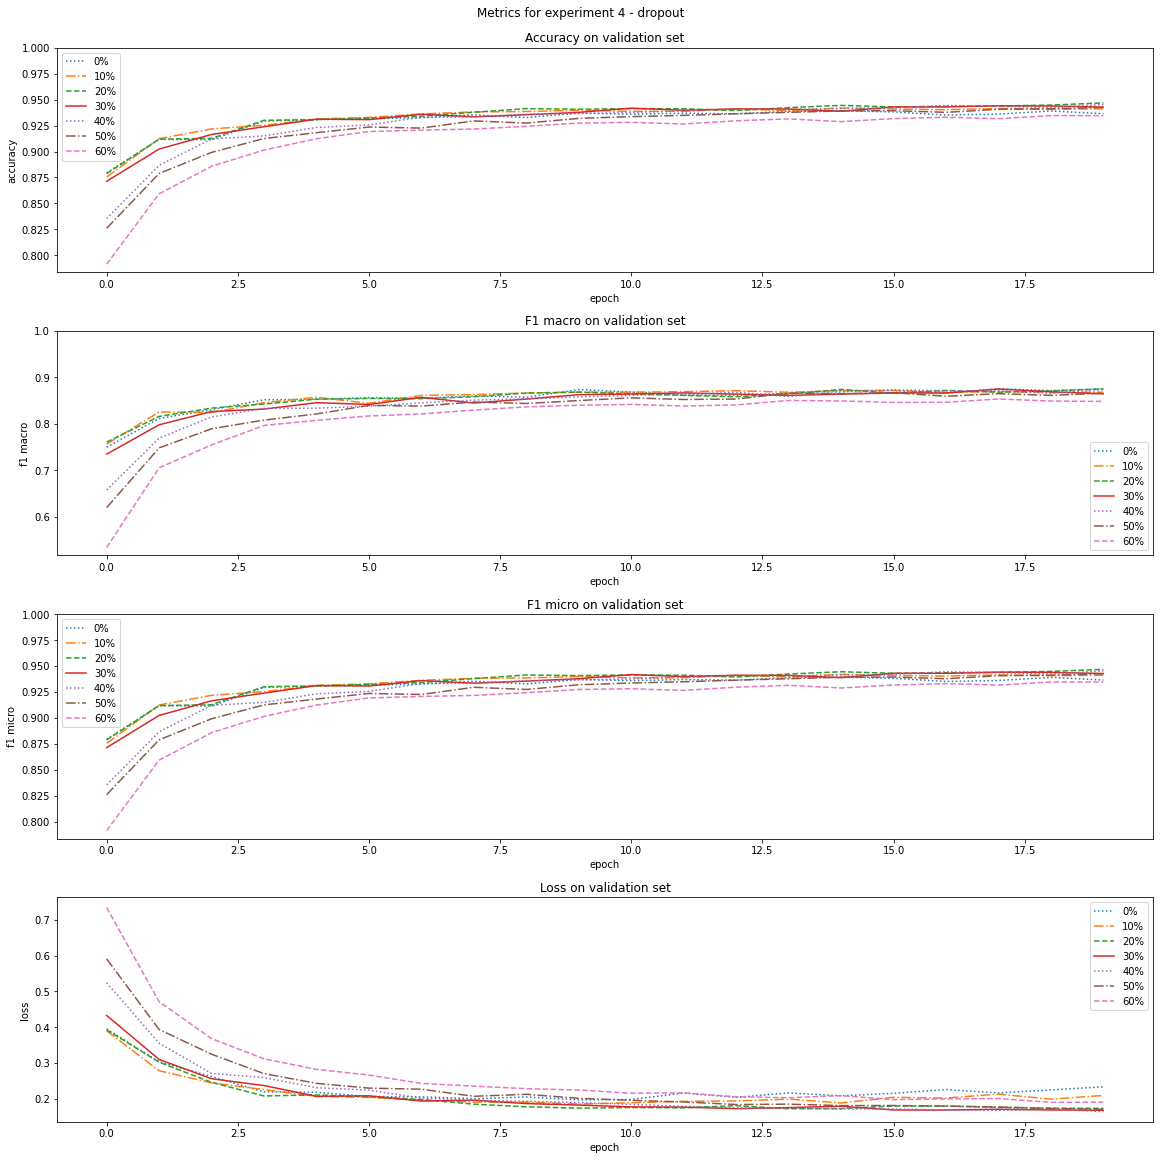

In [42]:
plot_metrics_for_experiment(history_4, 
                            f1_metrics_4, 
                            '4 - dropout',
                            ['0%', '10%', '20%', '30%', '40%', '50%', '60%'])

### Summary

The best dropout percentage is 30%.

## Experiment 5 - additional features

Lastly, this experiment will compare different additional techniques added on top of model built in previous experiments. Model combination testes follow:


*   \+ Early Stopping (although it's only to see if the model needs less than 20 epochs)
*   \+ Batch Normalization
*   \+ Data Augumentation
*    MaxPool replaced by Conv2d with stride (2) (P->C abbreviated) - this gives the architecture more nonlinearity and makes this layer learnable
*    P->C \+ Data Augumentation





In [32]:
experiment_nets = 5
model = [0]*experiment_nets

epochs = 30
history_5 = [0]*experiment_nets
f1_metrics_5 = [0]*experiment_nets


### \+ Early Stopping

In [33]:
m = 0
# Early Stopping
model[m] = Sequential()
model[m].add(Resizing(28, 28))
model[m].add(Conv2D(filters=32, kernel_size=5, activation='relu', input_shape=(28,28,1)))
model[m].add(MaxPool2D())
model[m].add(Dropout(0.3))
model[m].add(Conv2D(filters=64, kernel_size=5, activation='relu'))
model[m].add(MaxPool2D())
model[m].add(Dropout(0.3))
model[m].add(Flatten())
model[m].add(Dense(256, activation='relu'))
model[m].add(Dropout(0.3))
model[m].add(Dense(num_classes, activation='softmax'))
model[m].compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics='accuracy')


early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
fscore_metrics = MetricsCallback(X_train, y_train, X_test, y_test)
history_5[m] = model[m].fit(X_train, y_train, batch_size=80, epochs = epochs, 
      validation_data = (X_test, y_test), callbacks=[annealer, fscore_metrics, early_stopping_callback],
      verbose=False)
f1_metrics_5[m] = {"train_f1_macro": fscore_metrics.train_f_scores_macro,
                  "train_f1_micro": fscore_metrics.train_f_scores_micro,
                  "val_f1_macro": fscore_metrics.val_f_scores_macro,
                  "val_f1_micro": fscore_metrics.val_f_scores_micro
                }
print(f"Model {m}: Epochs={epochs} Train acc:{ max(history_5[m].history['accuracy'])} Val acc:{ max(history_5[m].history['val_accuracy']) }  Train f1: { max(fscore_metrics.train_f_scores_macro) } Test f1:{ max(fscore_metrics.val_f_scores_macro) }")


Model 0: Epochs=30 Train acc:0.9627519845962524 Val acc:0.9481146335601807  Train f1: 0.9394216212618027 Test f1:0.8812624112058733


In [34]:
len(history_5[0].history['accuracy'])

30

Note: In this experiment the early stopping has not been needed and was not used.

### \+ Batch Normalization

In [35]:
m=1
# Batch Normalization
model[m] = Sequential()
model[m].add(Resizing(28, 28))
model[m].add(Conv2D(filters=32, kernel_size=5, input_shape=(28,28,1)))
model[m].add(BatchNormalization())
model[m].add(Activation('relu'))
model[m].add(MaxPool2D())
model[m].add(Dropout(0.3))
model[m].add(Conv2D(filters=64, kernel_size=5))
model[m].add(BatchNormalization())
model[m].add(Activation('relu'))

model[m].add(MaxPool2D())
model[m].add(Dropout(0.3))
model[m].add(Flatten())
model[m].add(Dense(256))
model[m].add(BatchNormalization())
model[m].add(Activation('relu'))

model[m].add(Dropout(0.3))
model[m].add(Dense(num_classes, activation='softmax'))
model[m].compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics='accuracy')

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
fscore_metrics = MetricsCallback(X_train, y_train, X_test, y_test)
history_5[m] = model[m].fit(X_train, y_train, batch_size=80, epochs = epochs, 
      validation_data = (X_test, y_test), callbacks=[annealer, fscore_metrics, early_stopping_callback],
      verbose=False)
f1_metrics_5[m] = {"train_f1_macro": fscore_metrics.train_f_scores_macro,
                  "train_f1_micro": fscore_metrics.train_f_scores_micro,
                  "val_f1_macro": fscore_metrics.val_f_scores_macro,
                  "val_f1_micro": fscore_metrics.val_f_scores_micro
                }
print(f"Model {m}: Epochs={epochs} Train acc:{ max(history_5[m].history['accuracy'])} Val acc:{ max(history_5[m].history['val_accuracy']) }  Train f1: { max(fscore_metrics.train_f_scores_macro) } Test f1:{ max(fscore_metrics.val_f_scores_macro) }")


Model 1: Epochs=30 Train acc:0.9598791599273682 Val acc:0.9500251412391663  Train f1: 0.9093972052201968 Test f1:0.887065320514692


### \+ Data Generation

In [36]:
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1,
        preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)
        )


m=2
# Data Augumentation
model[m] = Sequential()
model[m].add(Resizing(28, 28))
model[m].add(Conv2D(filters=32, kernel_size=5, input_shape=(28,28,1)))

model[m].add(BatchNormalization())
model[m].add(Activation('relu'))

model[m].add(MaxPool2D())
model[m].add(Dropout(0.3))
model[m].add(Conv2D(filters=64, kernel_size=5))
model[m].add(BatchNormalization())
model[m].add(Activation('relu'))

model[m].add(MaxPool2D())
model[m].add(Dropout(0.3))
model[m].add(Flatten())
model[m].add(Dense(256))
model[m].add(BatchNormalization())
model[m].add(Activation('relu'))

model[m].add(Dropout(0.3))
model[m].add(Dense(num_classes, activation='softmax'))

model[m].compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
fscore_metrics_da = MetricsCallback(X_train, y_train, X_test, y_test)

history_5[m] = model[m].fit(datagen.flow(X_train, y_train, batch_size=100, shuffle=False), 
                            epochs = epochs, 
                            steps_per_epoch = X_train.shape[0] // 100,
                            validation_data = (X_test, y_test),
                            # validation_data = val_datagen.flow(X_test, y_test, shuffle=False),
                            # validation_steps = 35,
                            callbacks=[annealer, fscore_metrics_da, early_stopping_callback],
                            verbose=0)

f1_metrics_5[m] = {"train_f1_macro": fscore_metrics_da.train_f_scores_macro,
                  "train_f1_micro": fscore_metrics_da.train_f_scores_micro,
                   "train_accuracy": fscore_metrics_da.train_accuracy,
                  "val_f1_macro": fscore_metrics_da.val_f_scores_macro,
                  "val_f1_micro": fscore_metrics_da.val_f_scores_micro,
                   "val_accuracy":fscore_metrics_da.val_accuracy
                }
print(f"Model {m}: Epochs={epochs} Train acc:{ max(fscore_metrics_da.train_accuracy) } Val acc:{ max(fscore_metrics_da.val_accuracy) }  Train f1: { max(fscore_metrics_da.train_f_scores_macro) } Test f1:{ max(fscore_metrics_da.val_f_scores_macro) }")


Model 2: Epochs=30 Train acc:0.9530437366882956 Val acc:0.9437908496732026  Train f1: 0.8617504790119922 Test f1:0.867334624306571


### MaxPool -> Conv2D with stride 2,2

In [37]:
m=3

model[m] = Sequential()
model[m].add(Resizing(28, 28))
model[m].add(Conv2D(32,kernel_size=5,activation='relu',input_shape=(28,28,1)))
model[m].add(Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu'))
model[m].add(Dropout(0.3))
model[m].add(Conv2D(64,kernel_size=5,activation='relu'))
model[m].add(Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu'))
model[m].add(Dropout(0.3))
model[m].add(Flatten())
model[m].add(Dense(256, activation='relu'))
model[m].add(Dropout(0.3))
model[m].add(Dense(num_classes, activation='softmax'))
model[m].compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])


early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
fscore_metrics = MetricsCallback(X_train, y_train, X_test, y_test)
history_5[m] = model[m].fit(X_train, y_train, batch_size=80, epochs = epochs, 
      validation_data = (X_test, y_test), callbacks=[annealer, fscore_metrics, early_stopping_callback],
      verbose=False)
f1_metrics_5[m] = {"train_f1_macro": fscore_metrics.train_f_scores_macro,
                  "train_f1_micro": fscore_metrics.train_f_scores_micro,
                  "val_f1_macro": fscore_metrics.val_f_scores_macro,
                  "val_f1_micro": fscore_metrics.val_f_scores_micro
                }
print(f"Model {m}: Epochs={epochs} Train acc:{ max(history_5[m].history['accuracy'])} Val acc:{ max(history_5[m].history['val_accuracy']) }  Train f1: { max(fscore_metrics.train_f_scores_macro) } Test f1:{ max(fscore_metrics.val_f_scores_macro) }")


Model 3: Epochs=30 Train acc:0.9719154238700867 Val acc:0.9504273533821106  Train f1: 0.9591619409775216 Test f1:0.887086565144385


### MaxPool -> Conv2D with stride (2,2) \+ Data Augumentation

In [38]:
m=4

model[m] = Sequential()
model[m].add(Resizing(28, 28))
model[m].add(Conv2D(32,kernel_size=5,activation='relu',input_shape=(28,28,1)))
model[m].add(Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu'))
model[m].add(Dropout(0.3))
model[m].add(Conv2D(64,kernel_size=5,activation='relu'))
model[m].add(Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu'))
model[m].add(Dropout(0.3))
model[m].add(Flatten())
model[m].add(Dense(256, activation='relu'))
model[m].add(Dropout(0.3))
model[m].add(Dense(num_classes, activation='softmax'))
model[m].compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])


early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
fscore_metrics_da = MetricsCallback(X_train, y_train, X_test, y_test)

history_5[m] = model[m].fit(datagen.flow(X_train, y_train, batch_size=100, shuffle=False), 
                            epochs = epochs, 
                            steps_per_epoch = X_train.shape[0] // 100,
                            validation_data = (X_test, y_test),
                            callbacks=[annealer, fscore_metrics_da, early_stopping_callback],
                            verbose=0)

f1_metrics_5[m] = {"train_f1_macro": fscore_metrics_da.train_f_scores_macro,
                  "train_f1_micro": fscore_metrics_da.train_f_scores_micro,
                   "train_accuracy": fscore_metrics_da.train_accuracy,
                  "val_f1_macro": fscore_metrics_da.val_f_scores_macro,
                  "val_f1_micro": fscore_metrics_da.val_f_scores_micro,
                   "val_accuracy":fscore_metrics_da.val_accuracy
                }
print(f"Model {m}: Epochs={epochs} Train acc:{ max(fscore_metrics_da.train_accuracy) } Val acc:{ max(fscore_metrics_da.val_accuracy) }  Train f1: { max(fscore_metrics_da.train_f_scores_macro) } Test f1:{ max(fscore_metrics_da.val_f_scores_macro) }")


Model 4: Epochs=30 Train acc:0.964386547129625 Val acc:0.9521367521367521  Train f1: 0.8846821756078058 Test f1:0.8850978646261979


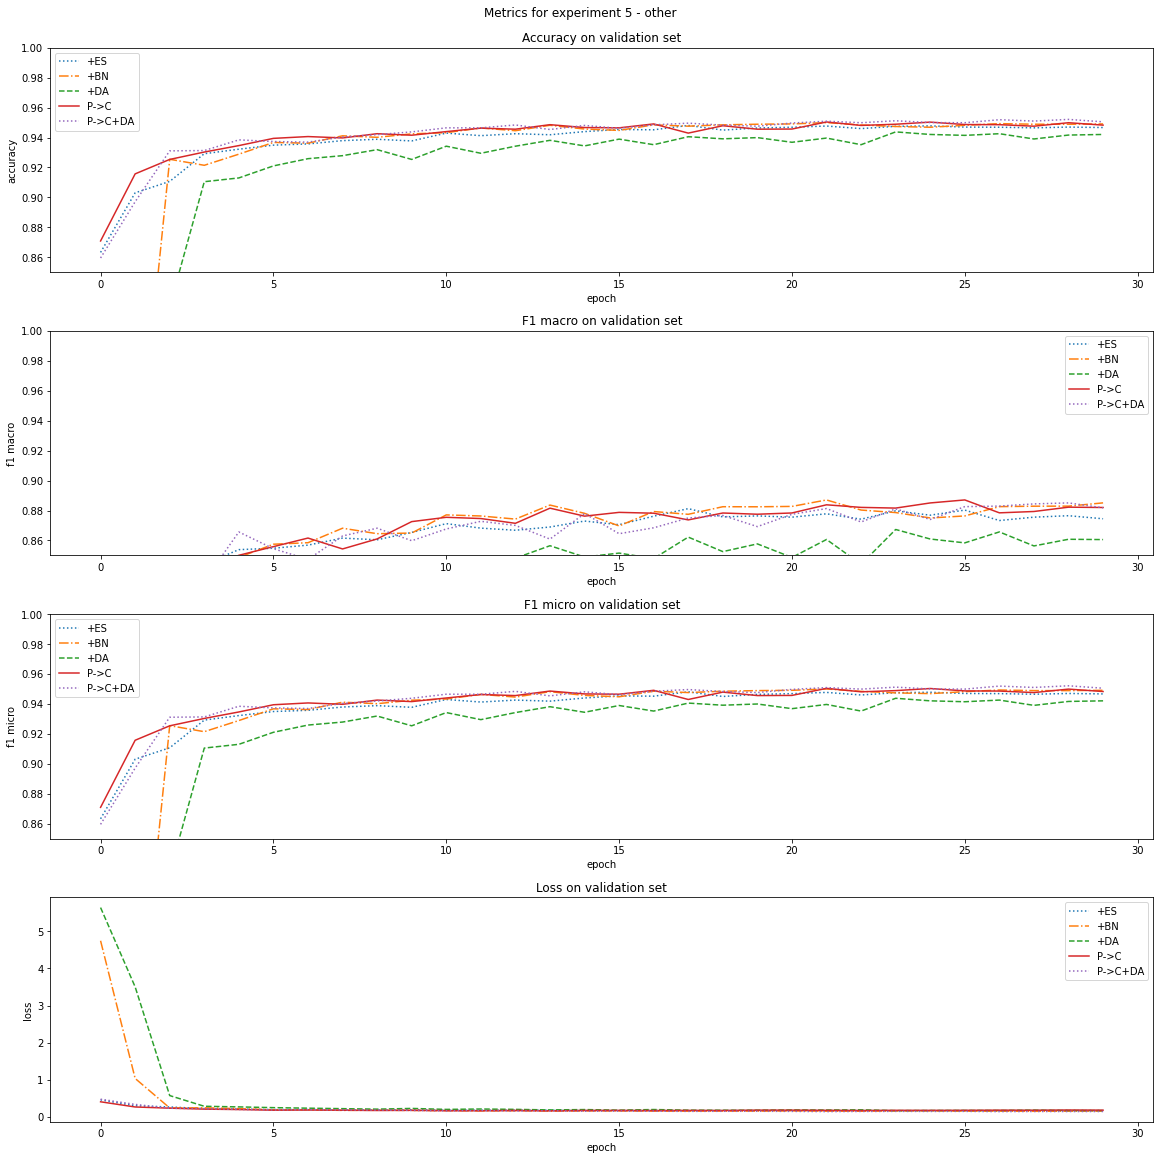

In [46]:
plot_metrics_for_experiment(history_5, 
                            f1_metrics_5, 
                            '5 - other',
                            ['+ES', '+BN', '+DA', 'P->C', 'P->C+DA'], truncate=True, truncation=0.85)

### Summary
The best results are achieved using model 'P->C+DA' which stands for model with MaxPool replaced by Conv2d with stride (2). This model achieves best results in all metrics.

In [53]:
print(f"Accuracy: { max(f1_metrics_5[-1]['val_accuracy']) }")
print(f"F1 score micro: { max(f1_metrics_5[-1]['val_f1_micro'])}")
print(f"F1 score macro: { max(f1_metrics_5[-1]['val_f1_macro']) }")


Accuracy: 0.9521367521367521
F1 score micro: 0.9521367521367521
F1 score macro: 0.8850978646261979


### Training using class weights
This adds 'more attention" for under-represented classes by weighting the loss function.

The best model from previous experiments will be trained using class weights to see if the results are better.

In [50]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train.flatten())
class_weight_dict = dict(enumerate(class_weights))

In [51]:
model = [0]
history_best = [0]
f1_metrics_best= [0]
m=0

model[m] = Sequential()
model[m].add(Resizing(28, 28))
model[m].add(Conv2D(32,kernel_size=5,activation='relu',input_shape=(28,28,1)))
model[m].add(Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu'))
model[m].add(Dropout(0.3))
model[m].add(Conv2D(64,kernel_size=5,activation='relu'))
model[m].add(Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu'))
model[m].add(Dropout(0.3))
model[m].add(Flatten())
model[m].add(Dense(256, activation='relu'))
model[m].add(Dropout(0.3))
model[m].add(Dense(num_classes, activation='softmax'))
model[m].compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])


early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
fscore_metrics_da = MetricsCallback(X_train, y_train, X_test, y_test)

history_best[m] = model[m].fit(datagen.flow(X_train, y_train, batch_size=100, shuffle=False), 
                            epochs = epochs, 
                            steps_per_epoch = X_train.shape[0] // 100,
                            validation_data = (X_test, y_test),
                            class_weight = class_weight_dict,
                            callbacks=[annealer, fscore_metrics_da, early_stopping_callback],
                            verbose=0)

f1_metrics_best[m] = {"train_f1_macro": fscore_metrics_da.train_f_scores_macro,
                  "train_f1_micro": fscore_metrics_da.train_f_scores_micro,
                   "train_accuracy": fscore_metrics_da.train_accuracy,
                  "val_f1_macro": fscore_metrics_da.val_f_scores_macro,
                  "val_f1_micro": fscore_metrics_da.val_f_scores_micro,
                   "val_accuracy":fscore_metrics_da.val_accuracy
                }
print(f"Model {m}: Epochs={epochs} Train acc:{ max(fscore_metrics_da.train_accuracy) } \
       Val acc:{ max(fscore_metrics_da.val_accuracy) }  Train f1: { max(fscore_metrics_da.train_f_scores_macro) } \
       Test f1:{ max(fscore_metrics_da.val_f_scores_macro) }")


Model 0: Epochs=30 Train acc:0.8701272970429442        Val acc:0.8593262946204122  Train f1: 0.8189902772585861        Test f1:0.807492314825709


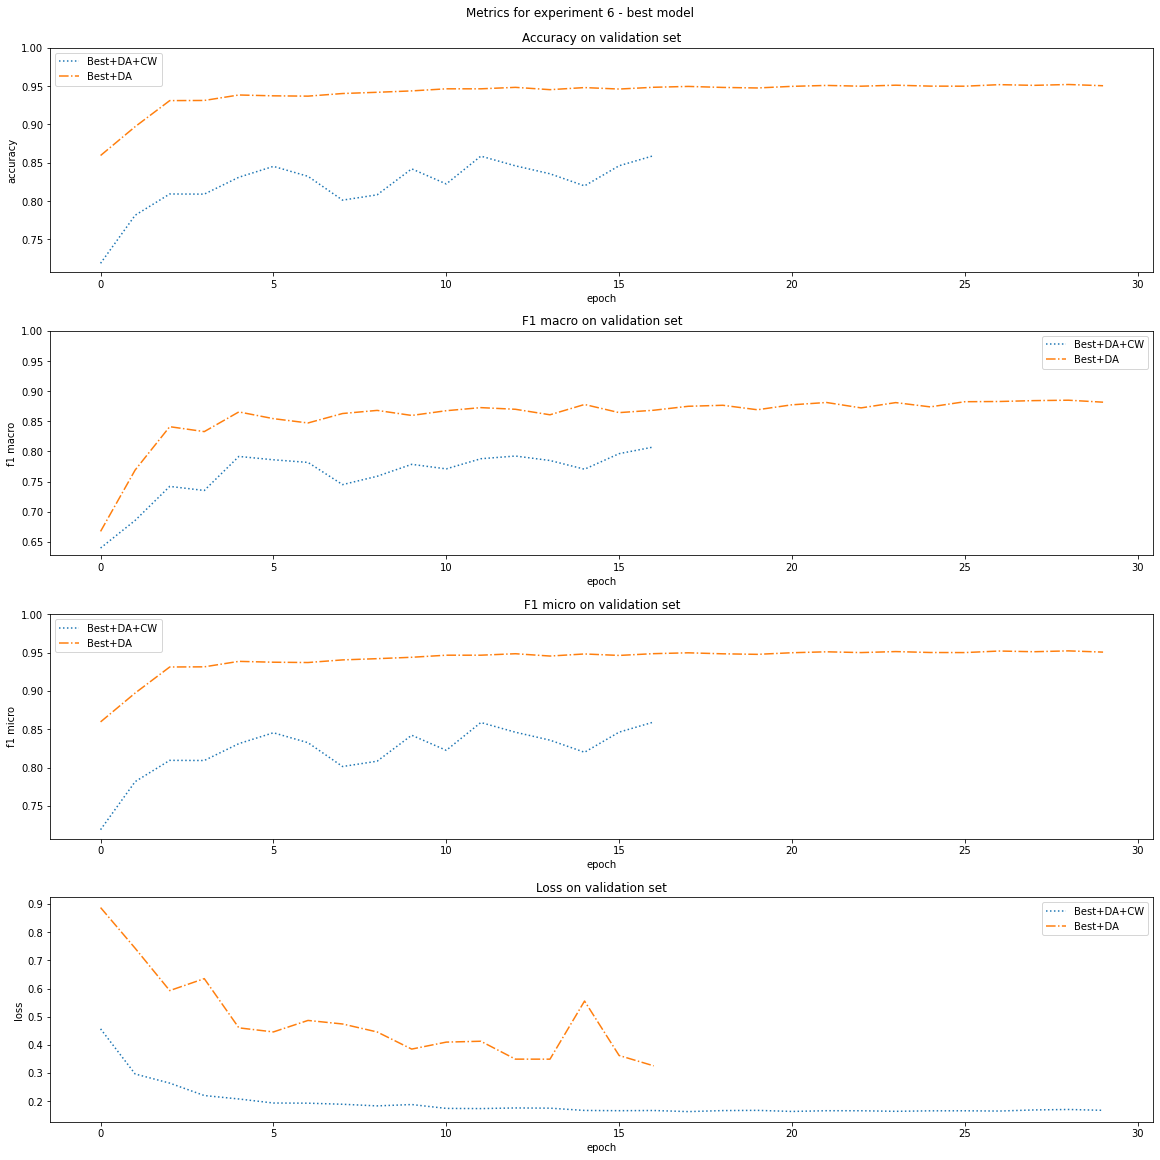

In [65]:
plot_metrics_for_experiment(hist_best, 
                            f1_metrics_best, 
                            '6 - best model',
                            ['Best+DA+CW','Best+DA'],
                            truncate=False)

Note: Unfortunately this method does not work well with this dataset. This means that alternative solutions should be tested.

In [93]:
best_model = model[-1]

In [95]:
!mkdir -p saved_model
best_model.save('saved_model/CNN-best')

INFO:tensorflow:Assets written to: saved_model/CNN-best/assets


In [97]:
!zip -r saved_model/CNN-best.zip /content/saved_model/CNN-best

  adding: content/saved_model/CNN-best/ (stored 0%)
  adding: content/saved_model/CNN-best/variables/ (stored 0%)
  adding: content/saved_model/CNN-best/variables/variables.index (deflated 68%)
  adding: content/saved_model/CNN-best/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: content/saved_model/CNN-best/saved_model.pb (deflated 90%)
  adding: content/saved_model/CNN-best/assets/ (stored 0%)


In [98]:
from google.colab import files
files.download("saved_model/CNN-best.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>